# Requirements

In [1]:
!pip install torch torchvision numpy matplotlib opencv-python

#Importing the dataset from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/RGB.zip" -d "/content/dataset"


Mounted at /content/drive


#Preparing the pairs of low/high resolution images


In [4]:
import os
import cv2
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

class SatelliteDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, target_size=(256, 256), transform=None):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder

        # Sort and match images
        self.lr_images = sorted(os.listdir(lr_folder))
        self.hr_images = sorted(os.listdir(hr_folder))

        # Match filenames (assumes LR_ and HR_ naming convention)
        common_images = set([img.split('_')[1] for img in self.lr_images])
        self.lr_images = [img for img in self.lr_images if img.split('_')[1] in common_images]
        self.hr_images = [img for img in self.hr_images if img.split('_')[1] in common_images]

        if len(self.lr_images) != len(self.hr_images):
            raise ValueError(f"Mismatch in dataset: LR={len(self.lr_images)}, HR={len(self.hr_images)}")

        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_folder, self.lr_images[idx])
        hr_path = os.path.join(self.hr_folder, self.hr_images[idx])

        lr_image = cv2.imread(lr_path, cv2.IMREAD_COLOR)
        hr_image = cv2.imread(hr_path, cv2.IMREAD_COLOR)

        lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
        hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

        lr_image = cv2.resize(lr_image, self.target_size)
        hr_image = cv2.resize(hr_image, self.target_size)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

# Dataset paths
lr_folder = "/content/dataset/RGB/Train/LR"
hr_folder = "/content/dataset/RGB/Train/HR"

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and split
dataset = SatelliteDataset(lr_folder, hr_folder, target_size=(256, 256), transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


#Plotting for sanity Check

4


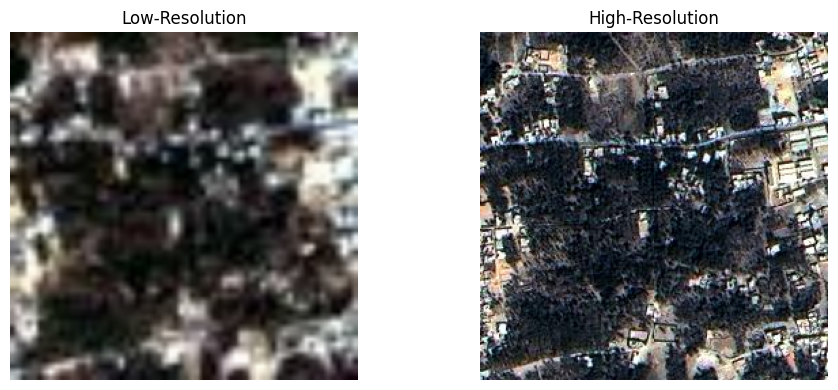

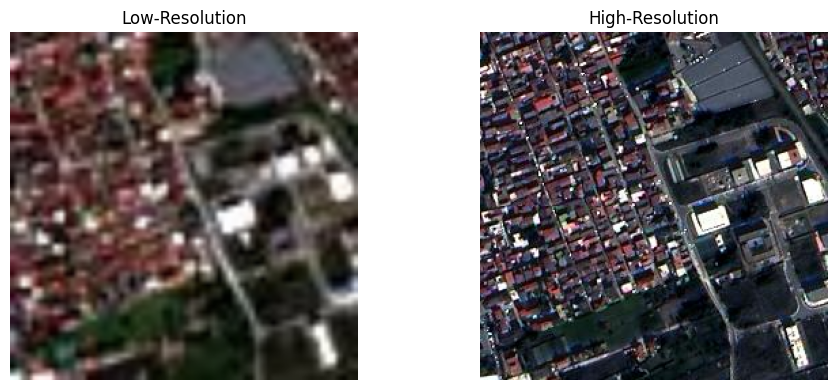

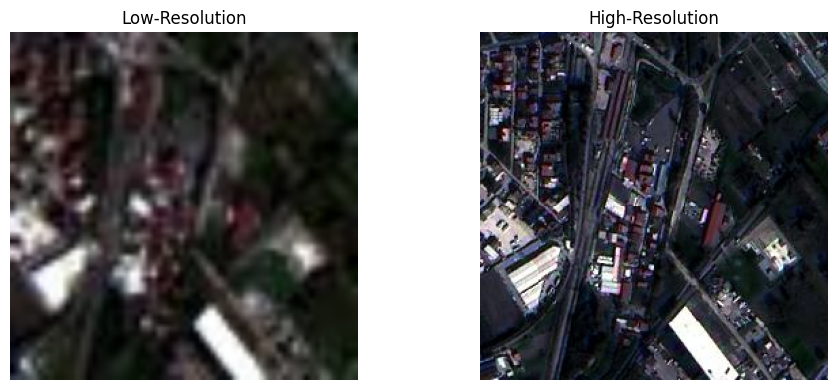

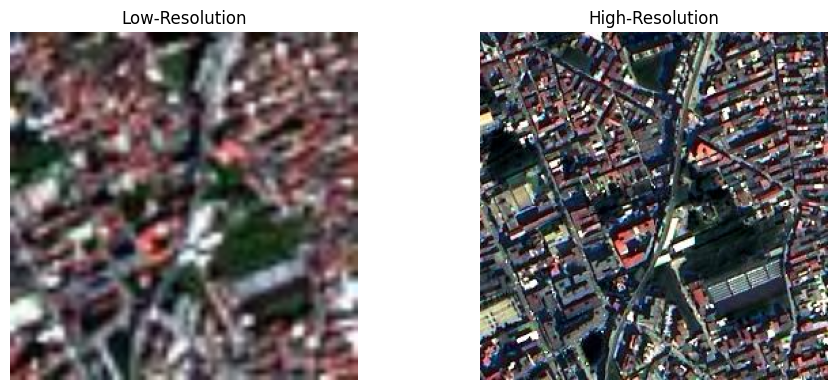

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert tensors to images
def tensor_to_image(tensor):
    # Move to CPU, remove batch dimension, and denormalize
    tensor = tensor.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
    tensor = tensor * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize
    tensor = np.clip(tensor, 0, 1)  # Clip values to valid range
    return tensor

# Get a batch of images
lr_batch, hr_batch = next(iter(train_dataloader))

# Visualize each LR and HR image pair in separate figures
num_images = 4  # Number of image pairs to display
print(num_images)

for i in range(num_images):
    plt.figure(figsize=(10, 4))  # Create a new figure for each pair

    # Low-Resolution Image
    plt.subplot(1, 2, 1)
    plt.imshow(tensor_to_image(lr_batch[i]))
    plt.title("Low-Resolution")
    plt.axis("off")

    # High-Resolution Image
    plt.subplot(1, 2, 2)
    plt.imshow(tensor_to_image(hr_batch[i]))
    plt.title("High-Resolution")
    plt.axis("off")

    plt.tight_layout()
    plt.show()  # Show the figure for this pair


#Creating save directory

In [6]:
import os
import torch

# Create directory to save models
save_path = "/content/models"
os.makedirs(save_path, exist_ok=True)


#Load and Map Pretrained RRDB-ESRGAN Model

In [8]:
import os
import torch
import RRDBNet_arch as arch

# Load pretrained model
pretrained_net = torch.load('/content/drive/MyDrive/models/RRDB_ESRGAN_x4..pth')
save_path = './models/RRDB_ESRGAN_x4.pth'

# Make sure the save directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Initialize the current model
crt_model = arch.RRDBNet(3, 3, 64, 23, gc=32)
crt_net = crt_model.state_dict()

# Remove 'module.' prefix if it exists
load_net_clean = {}
for k, v in pretrained_net.items():
    if k.startswith('module.'):
        load_net_clean[k[7:]] = v
    else:
        load_net_clean[k] = v
pretrained_net = load_net_clean

print('###################################\n')
tbd = []
for k, v in crt_net.items():
    tbd.append(k)

# Directly copy matching keys
for k, v in crt_net.items():
    if k in pretrained_net and pretrained_net[k].size() == v.size():
        crt_net[k] = pretrained_net[k]
        tbd.remove(k)

# Map the remaining keys
crt_net['conv_first.weight'] = pretrained_net['conv_first.weight']
crt_net['conv_first.bias'] = pretrained_net['conv_first.bias']

# RRDB trunk mapping
for i in range(23):  # Assuming 23 RRDB blocks
    for j in range(1, 4):  # RDBs inside each RRDB
        for conv in range(1, 6):  # Convs inside each RDB
            crt_key_weight = f'RRDB_trunk.{i}.RDB{j}.conv{conv}.weight'
            crt_key_bias = f'RRDB_trunk.{i}.RDB{j}.conv{conv}.bias'
            pre_key_weight = f'RRDB_trunk.{i}.RDB{j}.conv{conv}.weight'
            pre_key_bias = f'RRDB_trunk.{i}.RDB{j}.conv{conv}.bias'
            if pre_key_weight in pretrained_net:
                crt_net[crt_key_weight] = pretrained_net[pre_key_weight]
            if pre_key_bias in pretrained_net:
                crt_net[crt_key_bias] = pretrained_net[pre_key_bias]

crt_net['trunk_conv.weight'] = pretrained_net['trunk_conv.weight']
crt_net['trunk_conv.bias'] = pretrained_net['trunk_conv.bias']
crt_net['upconv1.weight'] = pretrained_net['upconv1.weight']
crt_net['upconv1.bias'] = pretrained_net['upconv1.bias']
crt_net['upconv2.weight'] = pretrained_net['upconv2.weight']
crt_net['upconv2.bias'] = pretrained_net['upconv2.bias']
crt_net['HRconv.weight'] = pretrained_net['HRconv.weight']
crt_net['HRconv.bias'] = pretrained_net['HRconv.bias']
crt_net['conv_last.weight'] = pretrained_net['conv_last.weight']
crt_net['conv_last.bias'] = pretrained_net['conv_last.bias']

# Save the updated model
torch.save(crt_net, save_path)
print('Saved model to', save_path)


###################################

Saved model to ./models/RRDB_ESRGAN_x4.pth


In [9]:
print(pretrained_net.keys())


dict_keys(['conv_first.weight', 'conv_first.bias', 'RRDB_trunk.0.RDB1.conv1.weight', 'RRDB_trunk.0.RDB1.conv1.bias', 'RRDB_trunk.0.RDB1.conv2.weight', 'RRDB_trunk.0.RDB1.conv2.bias', 'RRDB_trunk.0.RDB1.conv3.weight', 'RRDB_trunk.0.RDB1.conv3.bias', 'RRDB_trunk.0.RDB1.conv4.weight', 'RRDB_trunk.0.RDB1.conv4.bias', 'RRDB_trunk.0.RDB1.conv5.weight', 'RRDB_trunk.0.RDB1.conv5.bias', 'RRDB_trunk.0.RDB2.conv1.weight', 'RRDB_trunk.0.RDB2.conv1.bias', 'RRDB_trunk.0.RDB2.conv2.weight', 'RRDB_trunk.0.RDB2.conv2.bias', 'RRDB_trunk.0.RDB2.conv3.weight', 'RRDB_trunk.0.RDB2.conv3.bias', 'RRDB_trunk.0.RDB2.conv4.weight', 'RRDB_trunk.0.RDB2.conv4.bias', 'RRDB_trunk.0.RDB2.conv5.weight', 'RRDB_trunk.0.RDB2.conv5.bias', 'RRDB_trunk.0.RDB3.conv1.weight', 'RRDB_trunk.0.RDB3.conv1.bias', 'RRDB_trunk.0.RDB3.conv2.weight', 'RRDB_trunk.0.RDB3.conv2.bias', 'RRDB_trunk.0.RDB3.conv3.weight', 'RRDB_trunk.0.RDB3.conv3.bias', 'RRDB_trunk.0.RDB3.conv4.weight', 'RRDB_trunk.0.RDB3.conv4.bias', 'RRDB_trunk.0.RDB3.conv5.

#ESRGAN Super-Resolution and Evaluation on Test Images


In [10]:
import os
import os.path as osp
import cv2
import numpy as np
import torch
import glob
import RRDBNet_arch as arch

# Paths and setup
model_path = 'models/RRDB_ESRGAN_x4.pth'  # Adjust to your model path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_folder = '/content/dataset/RGB/Test'  # Input root folder
output_folder = '/content/results'        # Output root folder
os.makedirs(output_folder, exist_ok=True)

# Load the ESRGAN model
model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

print(f'Model path: {model_path}. \nProcessing images...')

idx = 0

# Walk through the entire directory tree
for subdir, _, files in os.walk(root_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):  # Supported image formats
            idx += 1
            full_file_path = osp.join(subdir, file)
            print(f'Processing {idx}: {full_file_path}')

            # Read and preprocess image
            img = cv2.imread(full_file_path, cv2.IMREAD_COLOR)
            img = img * 1.0 / 255
            img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
            img_LR = img.unsqueeze(0).to(device)

            # Super-resolution with the model
            with torch.no_grad():
                output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
            output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
            output = (output * 255.0).round()

            # Save the result while preserving directory structure
            relative_path = osp.relpath(subdir, root_folder)  # Retain folder structure
            output_dir = osp.join(output_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)           # Create output folder
            output_path = osp.join(output_dir, file)         # Keep original file name
            cv2.imwrite(output_path, output)

print('Processing completed. Results are saved in the results folder.')


Model path: models/RRDB_ESRGAN_x4.pth. 
Processing images...
Processing 1: /content/dataset/RGB/Test/Special/LR/LR_166.jpg
Processing 2: /content/dataset/RGB/Test/Special/LR/LR_158.jpg
Processing 3: /content/dataset/RGB/Test/Special/LR/LR_177.jpg
Processing 4: /content/dataset/RGB/Test/Special/LR/LR_192.jpg
Processing 5: /content/dataset/RGB/Test/Special/LR/LR_129.jpg
Processing 6: /content/dataset/RGB/Test/Special/LR/LR_114.jpg
Processing 7: /content/dataset/RGB/Test/Special/LR/LR_221.jpg
Processing 8: /content/dataset/RGB/Test/Special/LR/LR_203.jpg
Processing 9: /content/dataset/RGB/Test/Special/LR/LR_215.jpg
Processing 10: /content/dataset/RGB/Test/Special/LR/LR_79.jpg
Processing 11: /content/dataset/RGB/Test/Special/LR/LR_253.jpg
Processing 12: /content/dataset/RGB/Test/Special/LR/LR_161.jpg
Processing 13: /content/dataset/RGB/Test/Special/LR/LR_162.jpg
Processing 14: /content/dataset/RGB/Test/Special/LR/LR_265.jpg
Processing 15: /content/dataset/RGB/Test/Special/LR/LR_167.jpg
Proc

# Compress Results Folder into ZIP for Download

In [ ]:
!zip -r results.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/Special/ (stored 0%)
  adding: content/results/Special/LR/ (stored 0%)
  adding: content/results/Special/LR/LR_166.jpg (deflated 1%)
  adding: content/results/Special/LR/LR_158.jpg (deflated 1%)
  adding: content/results/Special/LR/LR_177.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_192.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_129.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_114.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_221.jpg (deflated 1%)
  adding: content/results/Special/LR/LR_203.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_215.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_79.jpg (deflated 1%)
  adding: content/results/Special/LR/LR_253.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_161.jpg (deflated 2%)
  adding: content/results/Special/LR/LR_162.jpg (deflated 1%)
  adding: content/results/Special/LR/LR_265.jpg (deflated 1